In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
header = ['attempt_id', 'step', 'sensor0', 'sensor1', 'sensor2', 'sensor3', 'sensor4',
             'sensor5', 'sensor6', 'sensor7', 'sensor8', 'sensor9',
             'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14',
             'action_L', 'action_R']
df = pd.read_csv('PID_logged_data final finished.csv', names=header)

In [5]:
attempt_time = df.groupby(df['attempt_id'])['step'].max() / 60
print(attempt_time.to_string(index=False))

attempt_id
20.983333
21.900000
22.366667
22.133333
13.116667
22.066667
21.250000
20.683333
22.283333
21.983333


In [6]:
attempt_time.mean()

20.876666666666665

In [7]:
# Define sensor columns
sensor_columns = [f'sensor{i}' for i in range(15)]

# Calculate line position based on active sensors
def calculate_line_position(row):
    active_sensors = [i for i, col in enumerate(sensor_columns) if row[col] == 1]
    return np.mean(active_sensors) if active_sensors else np.nan

df['line_position'] = df.apply(calculate_line_position, axis=1)

# Forward fill missing positions within each attempt
df['line_position'] = df.groupby('attempt_id')['line_position'].ffill()

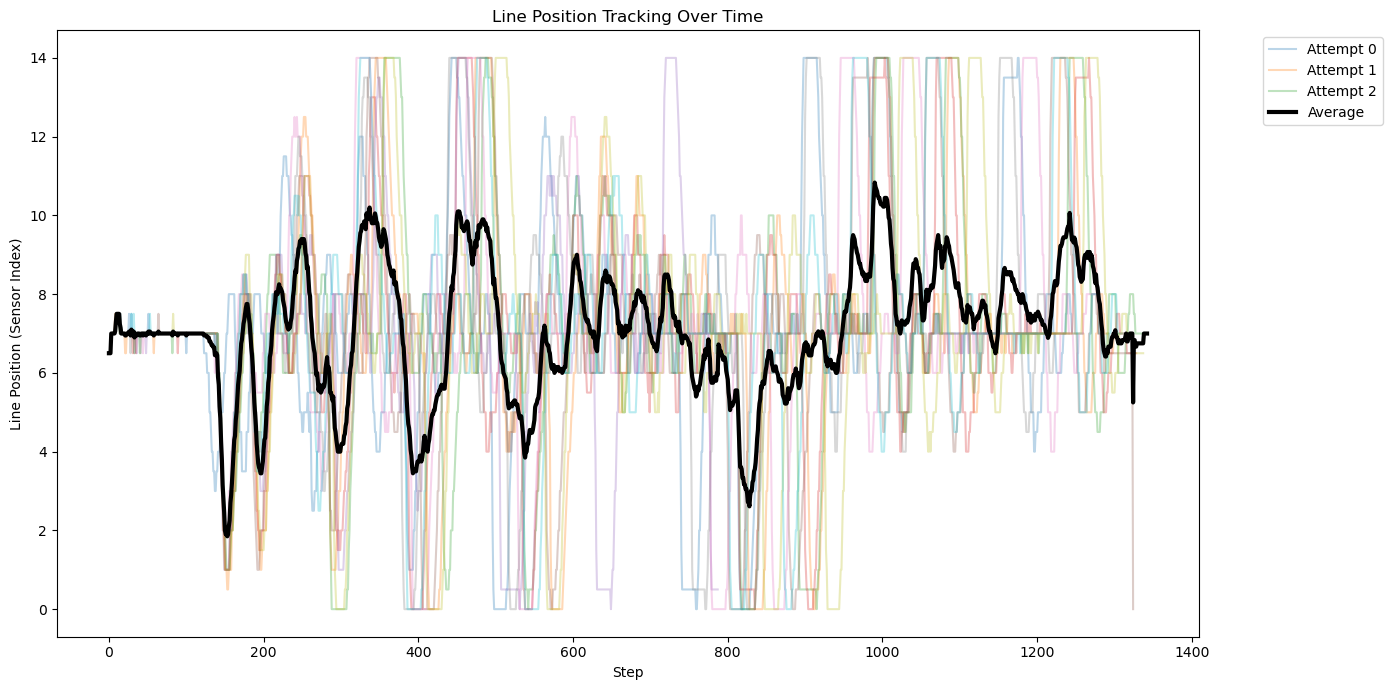

In [8]:
# Time Series Visualization
plt.figure(figsize=(14, 7))
attempt_ids = df['attempt_id'].unique()

# Plot individual attempts
for attempt_id in attempt_ids:
    attempt_data = df[df['attempt_id'] == attempt_id]
    plt.plot(attempt_data['step'], attempt_data['line_position'], 
             alpha=0.3, label=f'Attempt {attempt_id}' if attempt_id < 3 else "")

# Calculate and plot average line position
average_line = df.groupby('step')['line_position'].mean()
plt.plot(average_line.index, average_line.values, 
         color='black', linewidth=3, label='Average')

plt.title('Line Position Tracking Over Time')
plt.xlabel('Step')
plt.ylabel('Line Position (Sensor Index)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

C:\Users\Pc\AppData\Local\Temp\ipykernel_10180\1555536464.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sensor_counts.index, y=sensor_counts.values, palette='viridis')


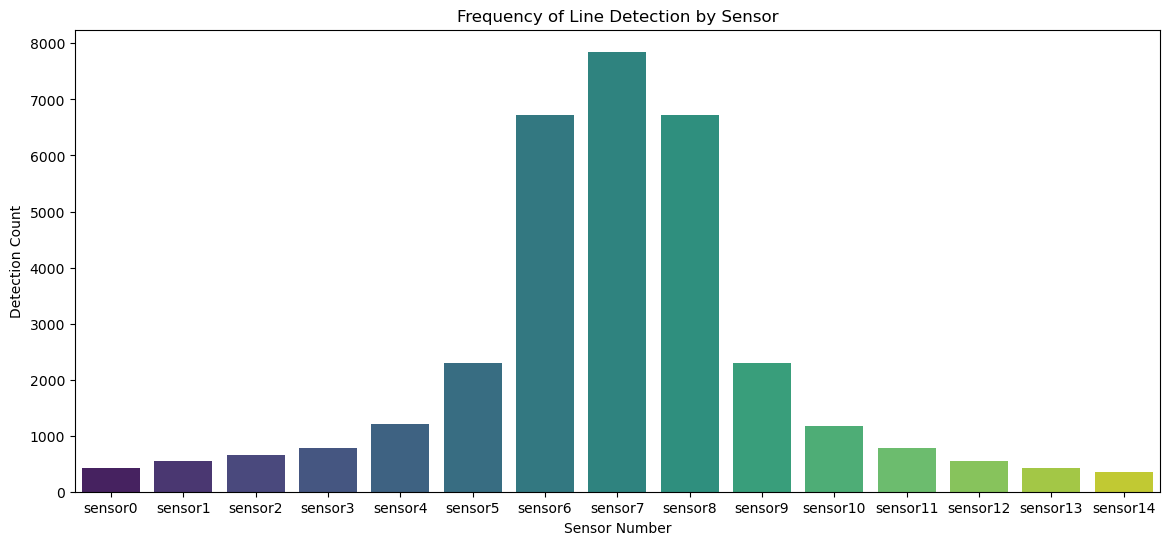

In [9]:
# Sensor Frequency Bar Chart
plt.figure(figsize=(14, 6))
sensor_counts = df[sensor_columns].sum()#.sort_values(ascending=False)
sns.barplot(x=sensor_counts.index, y=sensor_counts.values, palette='viridis')
plt.title('Frequency of Line Detection by Sensor')
plt.xlabel('Sensor Number')
plt.ylabel('Detection Count')
plt.show()

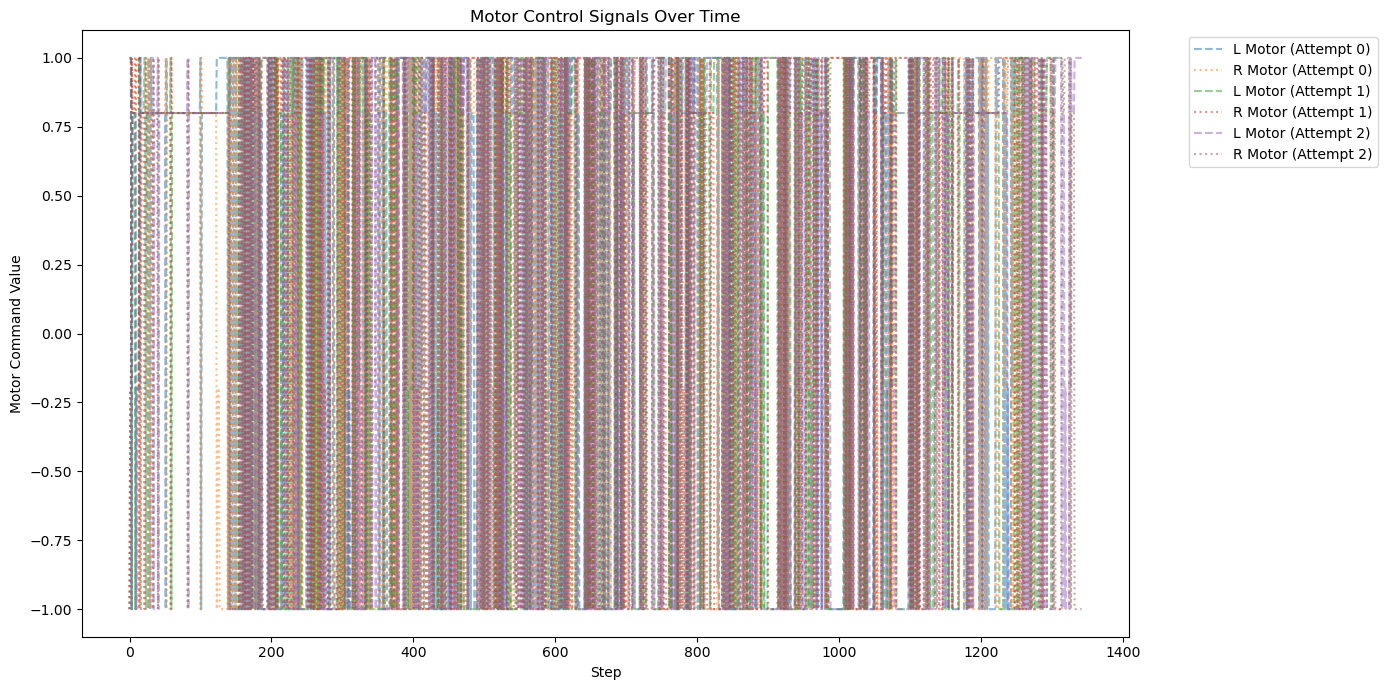

In [10]:
# Additional Visualization: Motor Actions Overlay
plt.figure(figsize=(14, 7))
for attempt_id in attempt_ids[:3]:  # Plot first 3 attempts for clarity
    attempt_data = df[df['attempt_id'] == attempt_id]
    plt.plot(attempt_data['step'], attempt_data['action_L'], 
             alpha=0.5, linestyle='--', label=f'L Motor (Attempt {attempt_id})')
    plt.plot(attempt_data['step'], attempt_data['action_R'], 
             alpha=0.5, linestyle=':', label=f'R Motor (Attempt {attempt_id})')

plt.title('Motor Control Signals Over Time')
plt.xlabel('Step')
plt.ylabel('Motor Command Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0, 0.5, 'sensor0'),
  Text(0, 1.5, 'sensor1'),
  Text(0, 2.5, 'sensor2'),
  Text(0, 3.5, 'sensor3'),
  Text(0, 4.5, 'sensor4'),
  Text(0, 5.5, 'sensor5'),
  Text(0, 6.5, 'sensor6'),
  Text(0, 7.5, 'sensor7'),
  Text(0, 8.5, 'sensor8'),
  Text(0, 9.5, 'sensor9'),
  Text(0, 10.5, 'sensor10'),
  Text(0, 11.5, 'sensor11'),
  Text(0, 12.5, 'sensor12'),
  Text(0, 13.5, 'sensor13'),
  Text(0, 14.5, 'sensor14')])

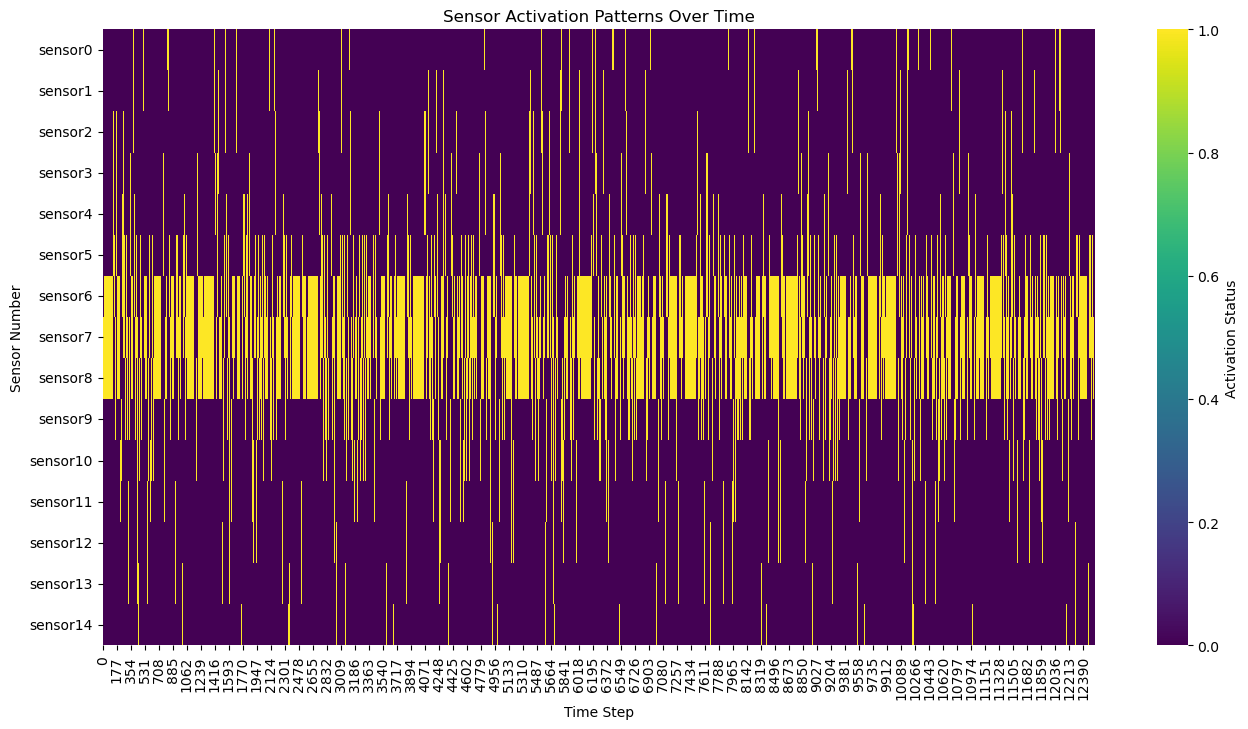

In [11]:
plt.figure(figsize=(16, 8))
sns.heatmap(df[sensor_columns].T, cmap='viridis', 
            cbar_kws={'label': 'Activation Status'})
plt.title('Sensor Activation Patterns Over Time')
plt.xlabel('Time Step')
plt.ylabel('Sensor Number')
plt.yticks(rotation=0)

Text(0, 0.5, 'Absolute Deviation (Sensor Units)')

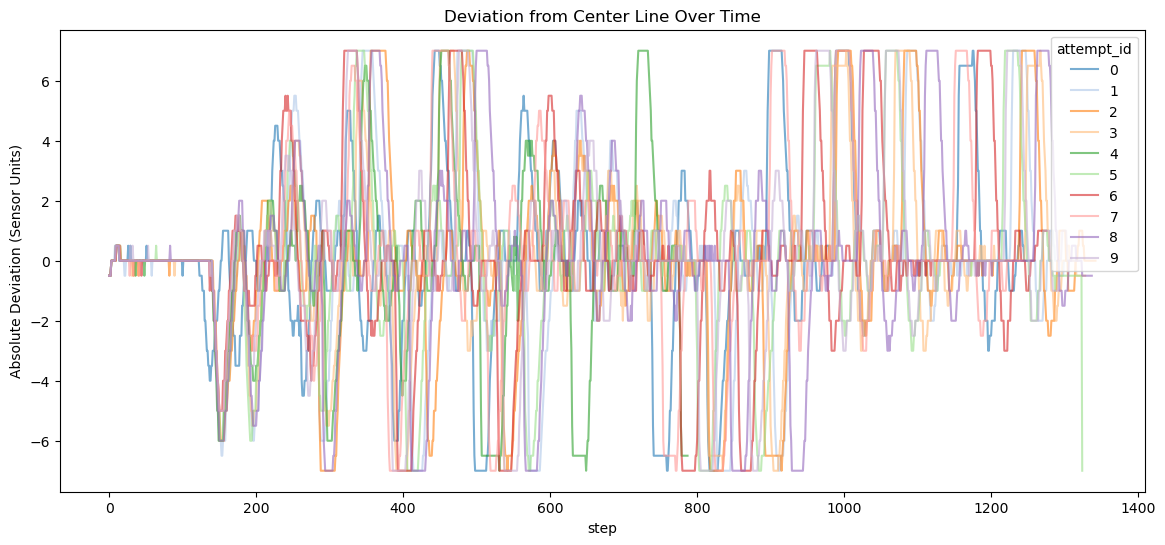

In [12]:
df['deviation'] = df['line_position'] - 7  # center is sensor 7
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='step', y='deviation', hue='attempt_id', 
             palette='tab20', alpha=0.6, estimator=None)
plt.title('Deviation from Center Line Over Time')
plt.ylabel('Absolute Deviation (Sensor Units)')

Text(0.5, 1.0, 'Correlation Matrix of Sensors and Control Signals')

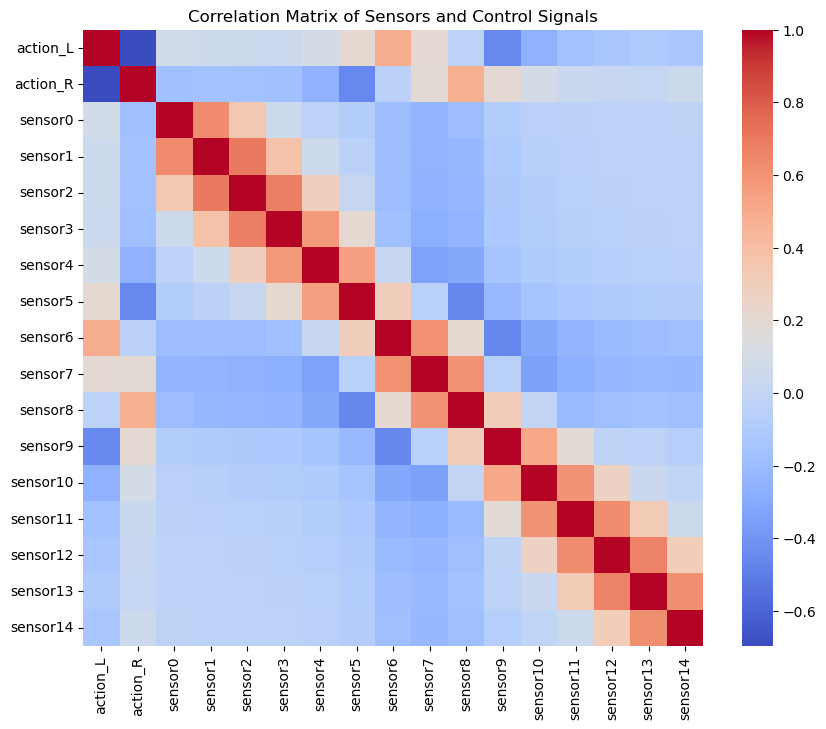

In [13]:
plt.figure(figsize=(10, 8))
corr_matrix = df[['action_L', 'action_R'] + sensor_columns].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Sensors and Control Signals')

Text(0, 0.5, 'Smoothed Line Position')

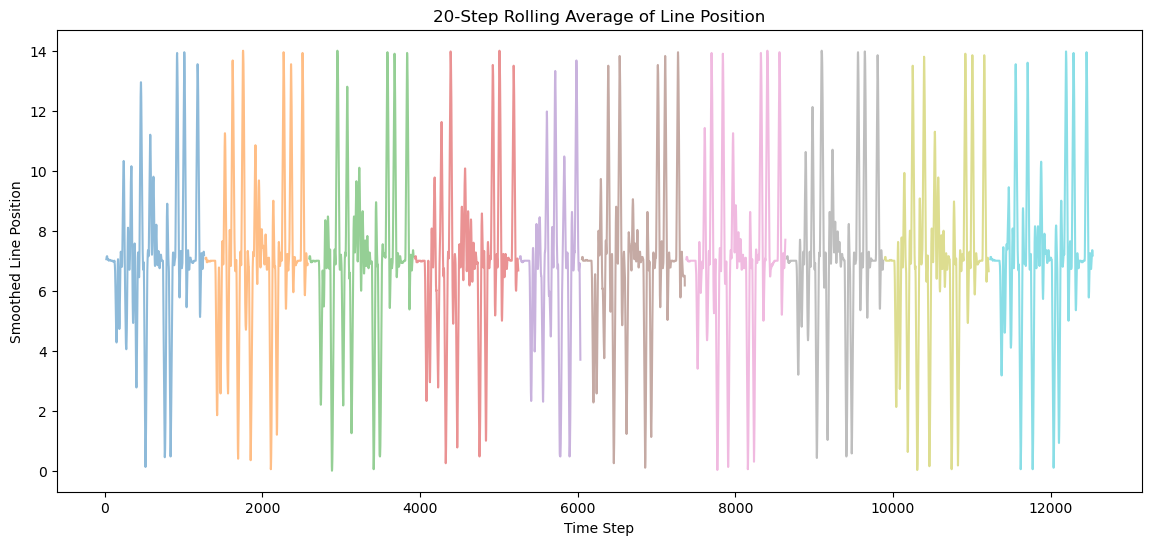

In [14]:
window_size = 20
plt.figure(figsize=(14, 6))
for attempt in df['attempt_id'].unique():
    attempt_data = df[df['attempt_id'] == attempt]
    rolling_avg = attempt_data['line_position'].rolling(window=window_size).mean()
    plt.plot(rolling_avg, alpha=0.5)

plt.title(f'{window_size}-Step Rolling Average of Line Position')
plt.xlabel('Time Step')
plt.ylabel('Smoothed Line Position')

Text(120.7222222222222, 0.5, 'Previous State')

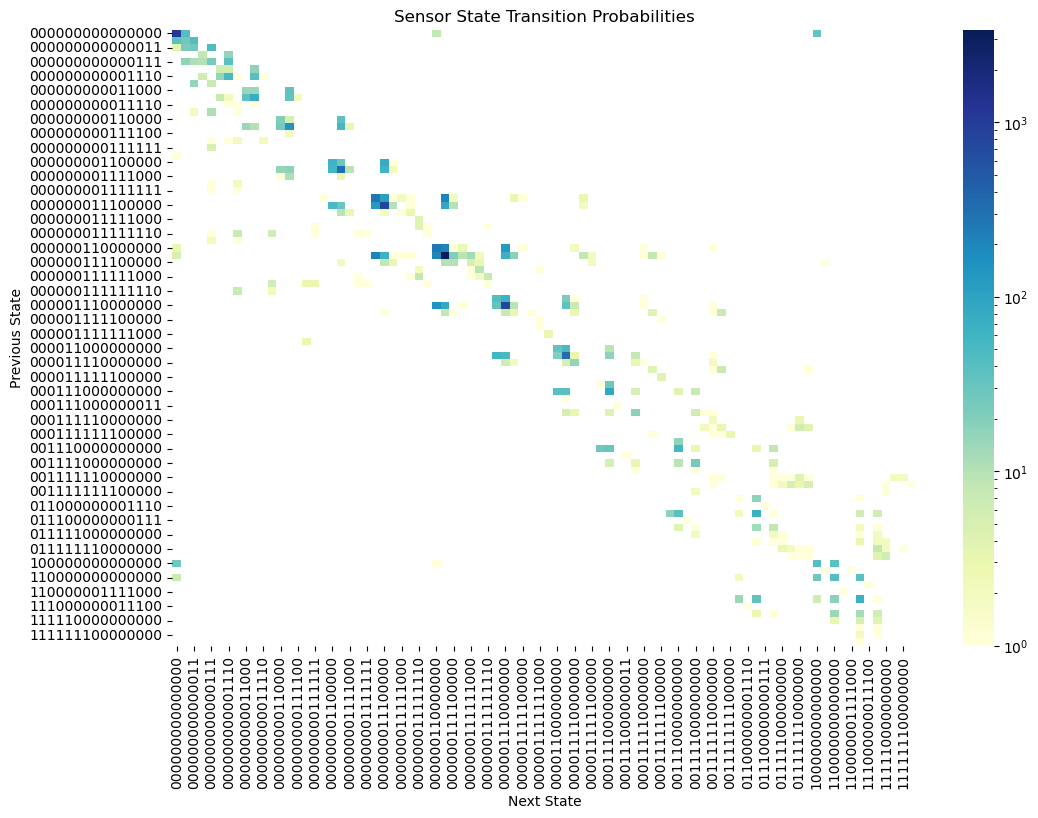

In [15]:
from matplotlib.colors import LogNorm

# Create transition matrix between sensor states
sensor_states = df[sensor_columns].astype(int).astype(str).sum(axis=1)
transitions = pd.Series(sensor_states).value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.heatmap(pd.crosstab(sensor_states.shift(), sensor_states), 
            norm=LogNorm(), cmap='YlGnBu')
plt.title('Sensor State Transition Probabilities')
plt.xlabel('Next State')
plt.ylabel('Previous State')

Text(0.5, 0, 'Attempt ID')

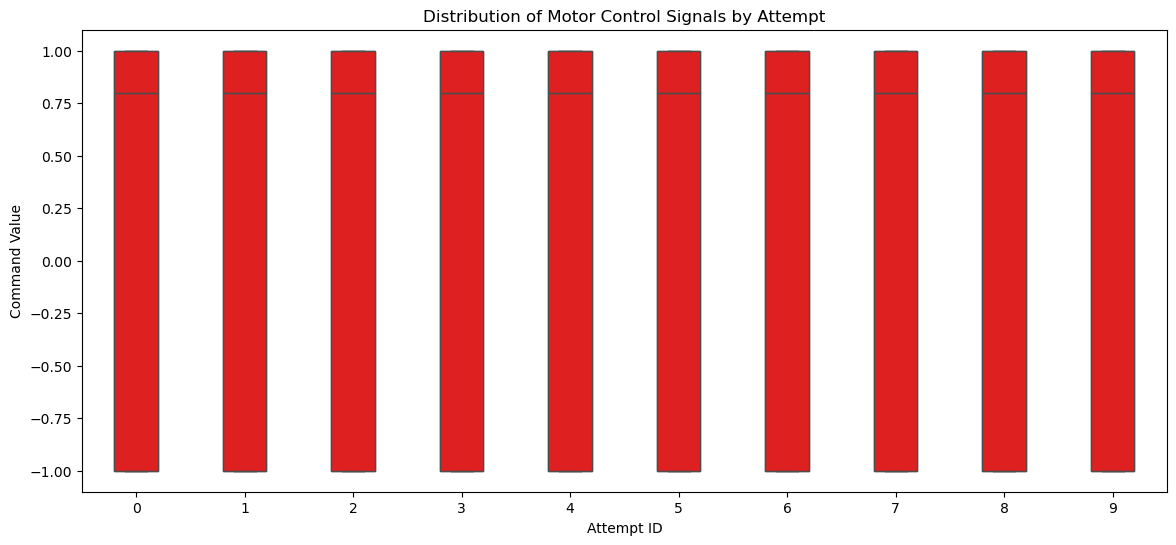

In [16]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='attempt_id', y='action_L', color='blue', width=0.4)
sns.boxplot(data=df, x='attempt_id', y='action_R', color='red', width=0.4)
plt.title('Distribution of Motor Control Signals by Attempt')
plt.ylabel('Command Value')
plt.xlabel('Attempt ID')

Text(0, 0.5, 'Lateral Position')

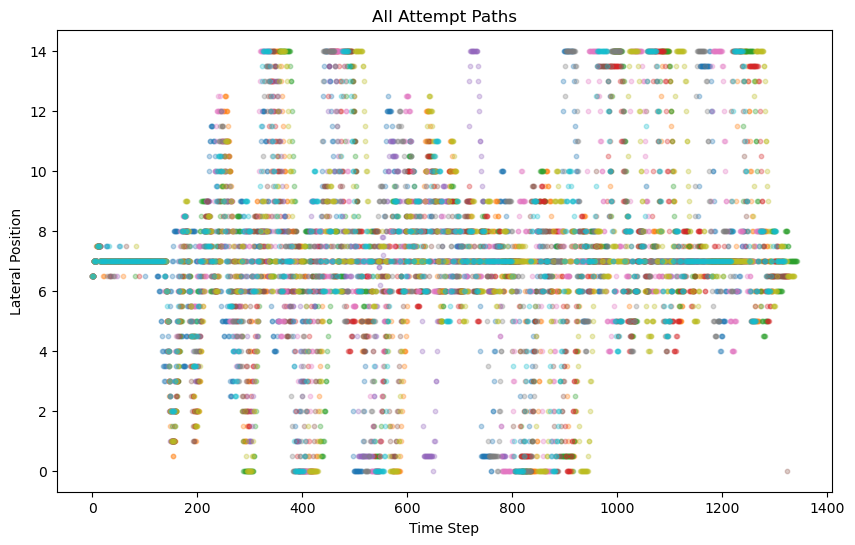

In [17]:
plt.figure(figsize=(10, 6))
for attempt in df['attempt_id'].unique():
    attempt_data = df[df['attempt_id'] == attempt]
    plt.scatter(attempt_data['step'], attempt_data['line_position'], 
                alpha=0.3, s=10)
plt.title('All Attempt Paths')
plt.xlabel('Time Step')
plt.ylabel('Lateral Position')

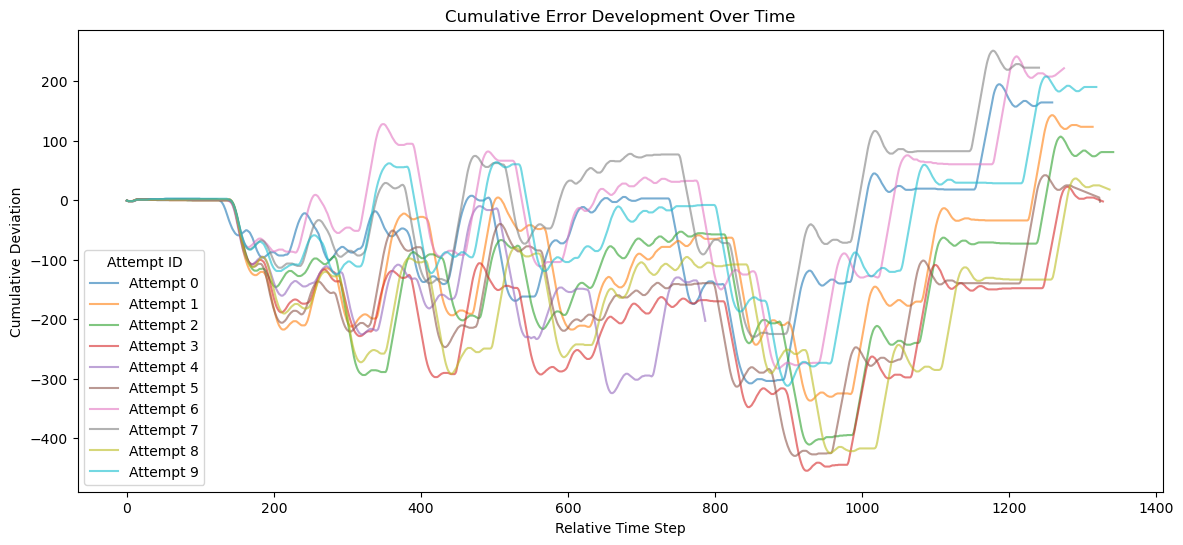

In [18]:
plt.figure(figsize=(14, 6))
for attempt in df['attempt_id'].unique():
    attempt_data = df[df['attempt_id'] == attempt].sort_values('step')
    cumulative_error = attempt_data['deviation'].cumsum()
    rel_steps = attempt_data['step'] - attempt_data['step'].iloc[0]
    plt.plot(rel_steps, cumulative_error, alpha=0.6, label=f'Attempt {attempt}')

plt.title('Cumulative Error Development Over Time')
plt.xlabel('Relative Time Step')
plt.ylabel('Cumulative Deviation')
plt.legend(title='Attempt ID')
plt.show()


In [27]:
import numpy as np
import pandas as pd
global attempt_time
# Store results here
results = []

# Loop through attempts and compute metrics
for attempt in df['attempt_id'].unique():
    attempt_data = df[df['attempt_id'] == attempt]
    
    total_error = attempt_data['deviation'].sum()
    rmse = np.sqrt(np.mean(np.square(attempt_data['deviation'])))
    
    results.append({
        'Attempt ID': attempt,
        'Total Error': total_error,
        'RMSE': rmse,
        'Time (seconds)': attempt_data['step'].max() / 60  # Convert steps to seconds
    })

# Convert to DataFrame for easier display
metrics_df = pd.DataFrame(results)

# Compute overall averages
average_total_error = metrics_df['Total Error'].mean()
average_rmse = metrics_df['RMSE'].mean()
average_time = metrics_df['Time (seconds)'].mean()

# Display the metrics
print("Per-Attempt Error Metrics:\n")
print(metrics_df.to_string(index=False))

print("\nAverage Across All Attempts:")
print(f"Average Total Error: {average_total_error:.4f}")
print(f"Average RMSE: {average_rmse:.4f}")
print(f"Average Time (seconds): {average_time:.2f}")


Per-Attempt Error Metrics:

 Attempt ID  Total Error     RMSE  Time (seconds)
          0        164.5 2.801183       20.983333
          1        123.5 3.063119       21.900000
          2         81.0 2.989744       22.366667
          3         -2.0 2.906364       22.133333
          4       -202.9 3.018301       13.116667
          5         -2.5 2.907343       22.066667
          6        222.0 3.081953       21.250000
          7        223.0 2.943168       20.683333
          8         18.0 3.116809       22.283333
          9        190.5 2.937448       21.983333

Average Across All Attempts:
Average Total Error: 81.5100
Average RMSE: 2.9765
Average Time (seconds): 20.88
